# UNet

En este notebook se implementa la arquitectura UNet para la segmentación de imágenes.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

In [1]:
# importamos las librerias necesarias
import os 
from pathlib import Path
from PIL import Image
import numpy as np

path = Path('./Dataset/Proyecto-SIS330.v13i.coco-segmentation') # Path del dataset
images_train = [path/'train'/i for i in os.listdir(path/'train')] # path de las imagenes de entrenamiento
mascaras_train = [path/'trainmasks'/i for i in os.listdir(path/'trainmasks')] # path de las mascaras de entrenamiento
images_test = [path/'test'/i for i in os.listdir(path/'test')] # path de las imagenes de test
mascaras_test = [path/'testmasks'/i for i in os.listdir(path/'testmasks')] # path de las mascaras de test

La función `cargar_imagenes_y_mascaras` carga las imágenes y las máscaras de la carpeta `data` y las devuelve en forma de `numpy array`. Esto con el fin de hacer algo más después, hiremos viendo el por qué.

In [3]:
# Función para cargar imágenes y máscaras como arrays de numpy
def cargar_imagenes_y_mascaras(img_paths, mask_paths):
    imagenes = []
    mascaras = []
    for img_path, mask_path in zip(img_paths, mask_paths):
        # Cargar imágenes y máscaras con Pillow
        imagen = Image.open(img_path)
        mascara = Image.open(mask_path)
        # convertir a float la imagen
        imagen = np.array(imagen)/255.
        # convertir a float la mascara
        mascara = np.array(mascara)/255.
        
        # Convertir imágenes y máscaras a arrays de numpy
        imagen_array = np.array(imagen)
        mascara_array = np.array(mascara)
        
        # Agregar arrays de numpy a las listas
        imagenes.append(imagen_array)
        mascaras.append(mascara_array)
    
    return np.array(imagenes), np.array(mascaras)

In [4]:
# Cargar imágenes y máscaras como arrays de numpy
imagenes_numpy, mascaras_numpy = cargar_imagenes_y_mascaras(images_test, mascaras_test)

# Verificar las formas de los arrays de numpy
print("Forma de las imágenes numpy:", imagenes_numpy.shape)
print("Forma de las máscaras numpy:", mascaras_numpy.shape)

Forma de las imágenes numpy: (605, 480, 864, 3)
Forma de las máscaras numpy: (605, 480, 864, 3)


Usamos las imagenes de test para hacer un ejercecio que haremos a continuación.

In [5]:
# cargamnos las imagenes y las mascaras
imgs = imagenes_numpy
masks = mascaras_numpy

In [6]:
# mostramos las dimensiones de las imagenes y las mascaras
imgs[0].shape, masks[0].shape

((480, 864, 3), (480, 864, 3))

Visualozamos las imagenes y las máscaras. Para ver que todo está bien y que las máscaras son correctas.

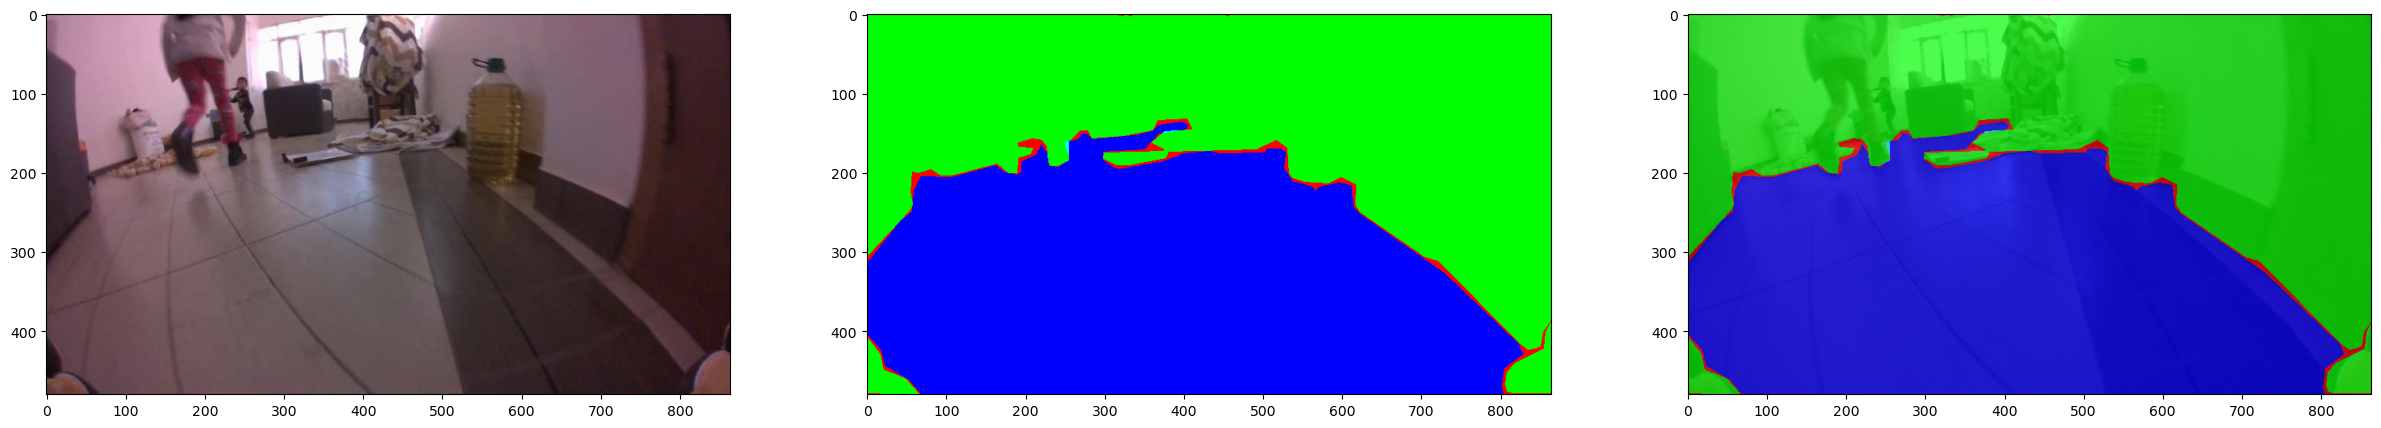

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import random

#idx = random.randint(0, len(imgs)-1)
#print(idx)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ix = 353
img = imgs[ix]
mask = masks[ix]
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(mask, alpha=0.7)
plt.show()

In [41]:
# verificamos la dimensión y el tipo de dato de las imagenes
img.shape, img.dtype, img.max(), img.min()

((480, 864, 3), dtype('float64'), 1.0, 0.011764705882352941)

In [42]:
# verificamos la dimensión y el tipo de dato de las mascaras
mask.shape, mask.dtype, mask.max(), mask.min()

((480, 864, 3), dtype('float64'), 1.0, 0.0)

## Modelo UNet

Aquí implementaremos el modelo `UNet`. Este modelo es una arquitectura de red neuronal convolucional para la segmentación de imágenes. Fue desarrollada en 2015 por Olaf Ronneberger, Philipp Fischer y Thomas Brox en la Universidad de Friburgo y ganó la competencia ISBI de segmentación de células neuronales. El modelo UNet se basa en una arquitectura de red neuronal totalmente convolucional para realizar la segmentación de imágenes. Su arquitectura se basa en una red neuronal convolucional en forma de U, por lo que se le llama UNet.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

### UNet con ResNet18

Para solucionar el problema anteriormente que obtuvimos, usaremos la arquitectura `ResNet18` que nos permitirá mejorar la precisión del modelo y haciendo uso del transfer learning.

In [2]:
import torch.nn.functional as F
import torch
import torchvision

# convolucional 3x3 con batch normalization y relu
def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

# clase decoder que recibe la salida de la capa anterior y la salida de la etapa
class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.Sequential(
                        torch.nn.Upsample(scale_factor=2, mode='bicubic'),
                        torch.nn.Conv2d(ci, co, kernel_size=1, stride=1)
                        )
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(weights='IMAGENET1K_V1')           
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = x.clone().detach()
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

Hacemos las pruebas para ver que todo está bien.

In [3]:
model = UNetResnet()
output = model(torch.randn((1,3,480,864)))
output.shape

torch.Size([1, 3, 480, 864])

### Hacemos el fit de una imagen

Haremos el fit de una imagen para ver que realmente esta funcionando el modelo. Para ello, usaremos la imagen `img` y la máscara `mask` de la función `cargar_imagenes_y_mascaras`.

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()  # Convertir X a tipo float
        y = y.float()  # Convertir y a tipo float
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Preparamos la imagen y la máscara con la que vamos a trabajar.

In [46]:
img_tensor = torch.tensor(img).unsqueeze(0).permute(0, 3, 1, 2)
mask_tensor = torch.tensor(mask).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 480, 864]), torch.Size([1, 3, 480, 864]))

In [47]:
# entrenamos el modelo con una imagen
fit(model, img_tensor, mask_tensor, epochs=50)

Epoch 1/50 loss 0.74172
Epoch 2/50 loss 0.69766
Epoch 3/50 loss 0.65188
Epoch 4/50 loss 0.60578
Epoch 5/50 loss 0.56731
Epoch 6/50 loss 0.53211
Epoch 7/50 loss 0.50330
Epoch 8/50 loss 0.47989
Epoch 9/50 loss 0.46060
Epoch 10/50 loss 0.44517
Epoch 11/50 loss 0.43255
Epoch 12/50 loss 0.42143
Epoch 13/50 loss 0.41186
Epoch 14/50 loss 0.40353
Epoch 15/50 loss 0.39617
Epoch 16/50 loss 0.38940
Epoch 17/50 loss 0.38356
Epoch 18/50 loss 0.37828
Epoch 19/50 loss 0.37350
Epoch 20/50 loss 0.36900
Epoch 21/50 loss 0.36494
Epoch 22/50 loss 0.36104
Epoch 23/50 loss 0.35729
Epoch 24/50 loss 0.35385
Epoch 25/50 loss 0.35051
Epoch 26/50 loss 0.34725
Epoch 27/50 loss 0.34417
Epoch 28/50 loss 0.34116
Epoch 29/50 loss 0.33817
Epoch 30/50 loss 0.33534
Epoch 31/50 loss 0.33261
Epoch 32/50 loss 0.32999
Epoch 33/50 loss 0.32749
Epoch 34/50 loss 0.32511
Epoch 35/50 loss 0.32275
Epoch 36/50 loss 0.32042
Epoch 37/50 loss 0.31811
Epoch 38/50 loss 0.31579
Epoch 39/50 loss 0.31351
Epoch 40/50 loss 0.31129
Epoch 41/

Vemos que el error es demasiado pequeño lo cual nos indica que el modelo está funcionando correctamente.


Pero ahora implementaremos una métrica para medir la precisión del modelo. Para ello, usaremos el `IoU` o `Intersection over Union` que es una métrica que se usa para medir la precisión de un modelo de segmentación. Para ello, usaremos la función `iou_metric` que nos calcula el `IoU` de la máscara predicha y la máscara real.

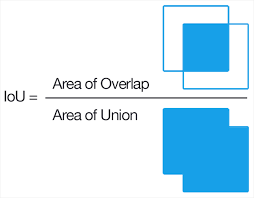

In [4]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        X = X.float()
        y = y.float()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [49]:
# entrenamos el modelo con una sola imagen
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.28901 iou 0.66811
Epoch 2/100 loss 0.79116 iou 0.08113
Epoch 3/100 loss 0.62814 iou 0.18761
Epoch 4/100 loss 0.57086 iou 0.18180
Epoch 5/100 loss 0.56433 iou 0.17511
Epoch 6/100 loss 0.48493 iou 0.29694
Epoch 7/100 loss 0.42678 iou 0.37778
Epoch 8/100 loss 0.37863 iou 0.43444
Epoch 9/100 loss 0.33428 iou 0.49187
Epoch 10/100 loss 0.31538 iou 0.50082
Epoch 11/100 loss 0.29544 iou 0.48667
Epoch 12/100 loss 0.28305 iou 0.48316
Epoch 13/100 loss 0.27022 iou 0.48756
Epoch 14/100 loss 0.26095 iou 0.48633
Epoch 15/100 loss 0.25338 iou 0.48562
Epoch 16/100 loss 0.24621 iou 0.48632
Epoch 17/100 loss 0.23907 iou 0.48792
Epoch 18/100 loss 0.23274 iou 0.48935
Epoch 19/100 loss 0.22749 iou 0.49011
Epoch 20/100 loss 0.22194 iou 0.49067
Epoch 21/100 loss 0.21631 iou 0.49045
Epoch 22/100 loss 0.21078 iou 0.49015
Epoch 23/100 loss 0.20526 iou 0.49029
Epoch 24/100 loss 0.20009 iou 0.49071
Epoch 25/100 loss 0.19509 iou 0.49098
Epoch 26/100 loss 0.19006 iou 0.49118
Epoch 27/100 loss 0.1

Vemos que el modelo consigue una precision del `99.12%` lo cual nos indica que el modelo está funcionando correctamente ya que al hacer fit de una sola imagen hacemos overfitting y por eso la precisión es tan alta.

Motramos y predicimos la segmentación de la imagen `img` y la máscara `mask` con la hicimos overfitting al modelo.

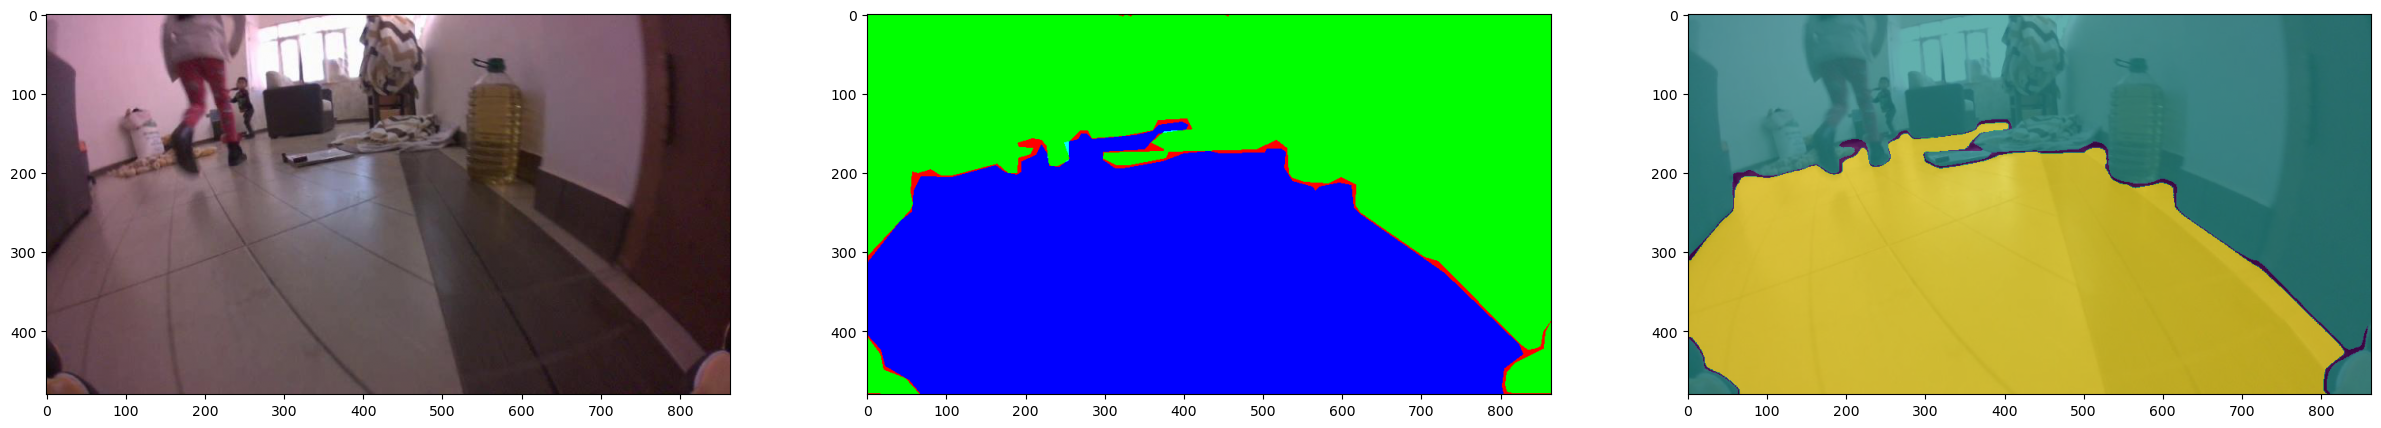

In [52]:
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0) #type: ignore
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img)
ax2.imshow(mask)
ax3.imshow(img)
ax3.imshow(pred_mask.squeeze().cpu().numpy(), alpha=0.7)
plt.show()

## Entrenamos con todo el dataset

Una vez tenido la certeza de que el modelo esta funcionando correctamente podemos seguir el siguiente paso, que es entrenar el modelo con todo el dataset para eso implementaremos clase `CustomDataset` que nos permitirá cargar el dataset completo y entrenar el modelo con el.

In [5]:
import torch
from torch.utils.data import Dataset
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, img_paths, mask_paths, transform=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        imagen = Image.open(self.img_paths[idx])
        mascara = Image.open(self.mask_paths[idx])

        # Convertir imágenes y máscaras a tensores de PyTorch
        X = torch.from_numpy(np.array(imagen) / 255.0).float().permute(2, 0, 1)
        y = torch.from_numpy(np.array(mascara) / 255.0).float().permute(2, 0, 1)

        if self.transform:
            # Aplicar transformación a las imágenes y máscaras
            X = self.transform(X)
            y = self.transform(y)

        return X, y

In [6]:
import torchvision.transforms as transforms

# aplicamos transformaciones a las imagenes
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# creamos el dataset
dataset = {
    'train': CustomDataset(images_train, mascaras_train),
    'test': CustomDataset(images_test, mascaras_test)
}
# verificamos el tamaño del dataset
len(dataset['train']), len(dataset['test'])

(5292, 605)

In [7]:
# vemos la dimensiones de la imagenes y mascaras del dataset
dataset['train'][0][0].shape, dataset['train'][0][1].shape

(torch.Size([3, 480, 864]), torch.Size([3, 480, 864]))

In [8]:
# cargamos el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=6, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=8, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([6, 3, 480, 864]), torch.Size([6, 3, 480, 864]))

Implementamos la función `fit` que nos permitirá entrenar el modelo con todo el dataset.

In [10]:
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader['train'])
        train_loss, train_iou = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            y_hat = model(imgs)
            loss = criterion(y_hat, masks)
            loss.backward()
            optimizer.step()
            ious = iou(y_hat, masks)
            train_loss.append(loss.item())
            train_iou.append(ious)
            bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['iou'].append(np.mean(train_iou))
        bar = tqdm(dataloader['test'])
        test_loss, test_iou = [], []
        model.eval()
        
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                y_hat = model(imgs)
                loss = criterion(y_hat, masks)
                ious = iou(y_hat, masks)
                test_loss.append(loss.item())
                test_iou.append(ious)
                bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_iou'].append(np.mean(test_iou))
        print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")

        torch.save(model.state_dict(), f"./models/UNetResNet_model_seg_v3_{epoch}.pt")
        
    return hist

#### Entrenamos el modelo

Entrenamos el modelo con todo el dataset. Para ello, usaremos la función `fit` que implementamos anteriormente. 

In [11]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=30)

test_loss 0.12264 test_iou 0.56757: 100%|██████████| 76/76 [00:58<00:00,  1.30it/s]



Epoch 1/30 loss 0.19620 iou 0.47838 test_loss 0.12264 test_iou 0.56757


test_loss 0.08668 test_iou 0.60139: 100%|██████████| 76/76 [01:01<00:00,  1.24it/s]



Epoch 2/30 loss 0.10293 iou 0.58805 test_loss 0.08668 test_iou 0.60139


test_loss 0.06460 test_iou 0.60039: 100%|██████████| 76/76 [00:58<00:00,  1.31it/s]



Epoch 3/30 loss 0.08113 iou 0.60220 test_loss 0.06460 test_iou 0.60039


test_loss 0.07261 test_iou 0.59048: 100%|██████████| 76/76 [00:46<00:00,  1.63it/s]



Epoch 4/30 loss 0.06826 iou 0.60995 test_loss 0.07261 test_iou 0.59048


test_loss 0.06221 test_iou 0.60901: 100%|██████████| 76/76 [00:56<00:00,  1.33it/s]



Epoch 5/30 loss 0.06012 iou 0.61409 test_loss 0.06221 test_iou 0.60901


test_loss 0.05228 test_iou 0.61254: 100%|██████████| 76/76 [00:58<00:00,  1.30it/s]



Epoch 6/30 loss 0.05472 iou 0.61690 test_loss 0.05228 test_iou 0.61254


test_loss 0.05173 test_iou 0.61914: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 7/30 loss 0.04623 iou 0.62330 test_loss 0.05173 test_iou 0.61914


test_loss 0.05736 test_iou 0.61446: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 8/30 loss 0.04533 iou 0.62440 test_loss 0.05736 test_iou 0.61446


test_loss 0.05483 test_iou 0.61271: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]



Epoch 9/30 loss 0.04217 iou 0.62738 test_loss 0.05483 test_iou 0.61271


test_loss 0.06045 test_iou 0.61488: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 10/30 loss 0.03833 iou 0.62854 test_loss 0.06045 test_iou 0.61488


test_loss 0.05453 test_iou 0.61544: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 11/30 loss 0.03192 iou 0.63385 test_loss 0.05453 test_iou 0.61544


test_loss 0.05476 test_iou 0.63122: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 12/30 loss 0.02974 iou 0.63690 test_loss 0.05476 test_iou 0.63122


test_loss 0.06384 test_iou 0.62176: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 13/30 loss 0.03013 iou 0.63635 test_loss 0.06384 test_iou 0.62176


test_loss 0.06193 test_iou 0.61410: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 14/30 loss 0.02547 iou 0.63966 test_loss 0.06193 test_iou 0.61410


test_loss 0.04715 test_iou 0.63233: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 15/30 loss 0.02906 iou 0.63984 test_loss 0.04715 test_iou 0.63233


test_loss 0.05072 test_iou 0.62318: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 16/30 loss 0.02294 iou 0.64505 test_loss 0.05072 test_iou 0.62318


test_loss 0.05207 test_iou 0.62858: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]



Epoch 17/30 loss 0.02237 iou 0.64654 test_loss 0.05207 test_iou 0.62858


test_loss 0.05911 test_iou 0.61803: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 18/30 loss 0.02160 iou 0.64831 test_loss 0.05911 test_iou 0.61803


test_loss 0.05878 test_iou 0.62704: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]



Epoch 19/30 loss 0.02218 iou 0.64886 test_loss 0.05878 test_iou 0.62704


test_loss 0.06112 test_iou 0.61285: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 20/30 loss 0.01977 iou 0.65403 test_loss 0.06112 test_iou 0.61285


test_loss 0.06014 test_iou 0.63679: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]



Epoch 21/30 loss 0.01974 iou 0.65215 test_loss 0.06014 test_iou 0.63679


test_loss 0.05321 test_iou 0.63652: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 22/30 loss 0.01993 iou 0.65591 test_loss 0.05321 test_iou 0.63652


test_loss 0.05032 test_iou 0.63967: 100%|██████████| 76/76 [00:55<00:00,  1.37it/s]



Epoch 23/30 loss 0.01720 iou 0.66307 test_loss 0.05032 test_iou 0.63967


test_loss 0.05918 test_iou 0.63987: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 24/30 loss 0.02303 iou 0.65423 test_loss 0.05918 test_iou 0.63987


test_loss 0.05121 test_iou 0.65001: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 25/30 loss 0.01752 iou 0.66523 test_loss 0.05121 test_iou 0.65001


test_loss 0.05935 test_iou 0.63826: 100%|██████████| 76/76 [00:55<00:00,  1.38it/s]



Epoch 26/30 loss 0.01756 iou 0.66703 test_loss 0.05935 test_iou 0.63826


test_loss 0.05637 test_iou 0.63407: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]



Epoch 27/30 loss 0.01527 iou 0.67401 test_loss 0.05637 test_iou 0.63407


test_loss 0.06300 test_iou 0.62186: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 28/30 loss 0.01563 iou 0.67301 test_loss 0.06300 test_iou 0.62186


test_loss 0.05470 test_iou 0.64812: 100%|██████████| 76/76 [00:50<00:00,  1.49it/s]



Epoch 29/30 loss 0.01770 iou 0.66808 test_loss 0.05470 test_iou 0.64812


test_loss 0.06519 test_iou 0.63728: 100%|██████████| 76/76 [00:51<00:00,  1.49it/s]


Epoch 30/30 loss 0.01470 iou 0.67961 test_loss 0.06519 test_iou 0.63728


Vemos que la precisión de nuestro modelo es bastante bueno, la mejor llega al `94.43%` y con un error del `1.25%`, esto nos indica que el modelo está funcionando correctamente.

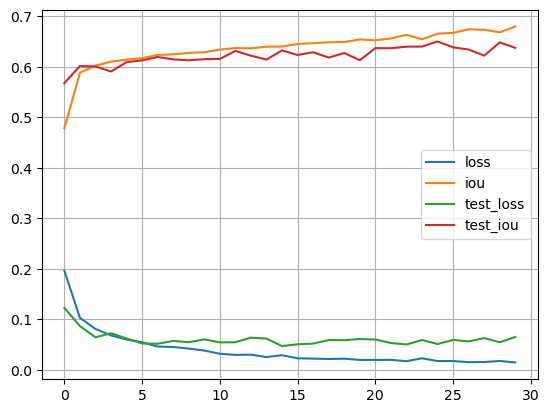

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

df_hist = pd.DataFrame(hist)
df_hist.to_csv('hist.csv', index=False)

In [18]:
import matplotlib.colors as mcolors

classes = ['camino', 'obstaculo', 'background']
colors = ['#1f77b4', '#ff9e80', '#9e9e9e'] # Colores fijos para cada clase

def plot_predict(img, mask, model):
    model.eval().to(device)
    with torch.no_grad():
        img = img.to(device)
        mask = mask.to(device)

        output = model(img)[0]
        pred_mask = torch.argmax(output, dim=0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
    ax1.set_title('Imagen', fontsize=25)
    ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    ax2.set_title('Máscara', fontsize=25)
    ax2.imshow(mask.squeeze().cpu().numpy())

    ax3.set_title('Predicción', fontsize=25)
    ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())

    # Asignar colores fijos a cada canal en la pred_mask (one-hot encoding)
    colored_mask = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
    for i in range(len(classes)):
        colored_mask[pred_mask.cpu() == i] = np.array(mcolors.to_rgba(colors[i], 1)[:3]) * 255  #type: ignore Obtener RGB de los colores fijos y escalar a [0, 255]

    ax3.imshow(colored_mask, alpha=0.8)

    # Crear una leyenda personalizada con colores fijos para cada clase
    legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=10, label=classes[i]) for i in range(len(classes))] # type: ignore

    # Agregar leyenda al tercer subplot
    ax3.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), bbox_transform=ax3.transAxes, fontsize=20)

    plt.show()

263


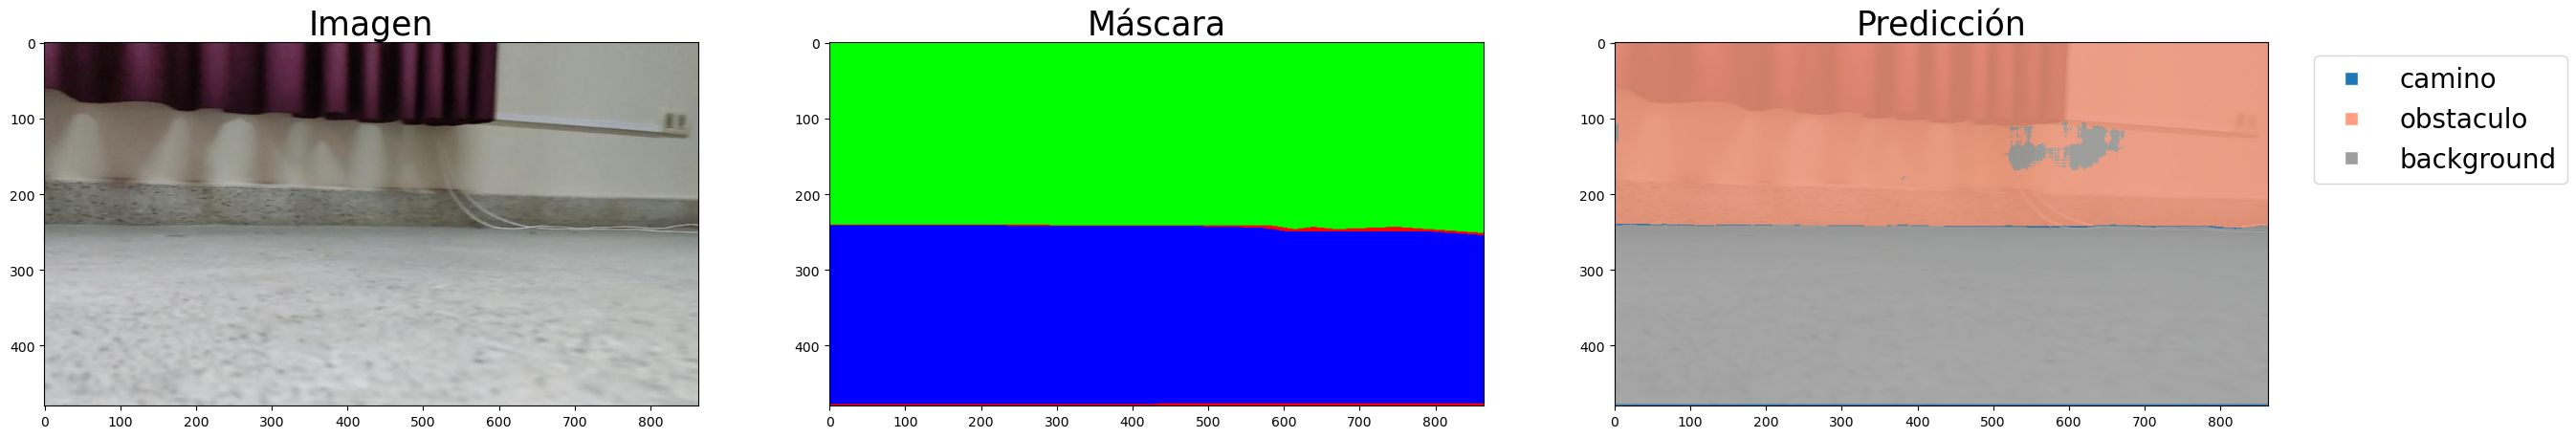

In [21]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
#ix = 99
print(ix)
img, mask = dataset['test'][ix]
img = img.clone().detach().unsqueeze(0).to(device).float()
mask = mask.clone().detach().permute(1, 2, 0)

plot_predict(img, mask, model)

361


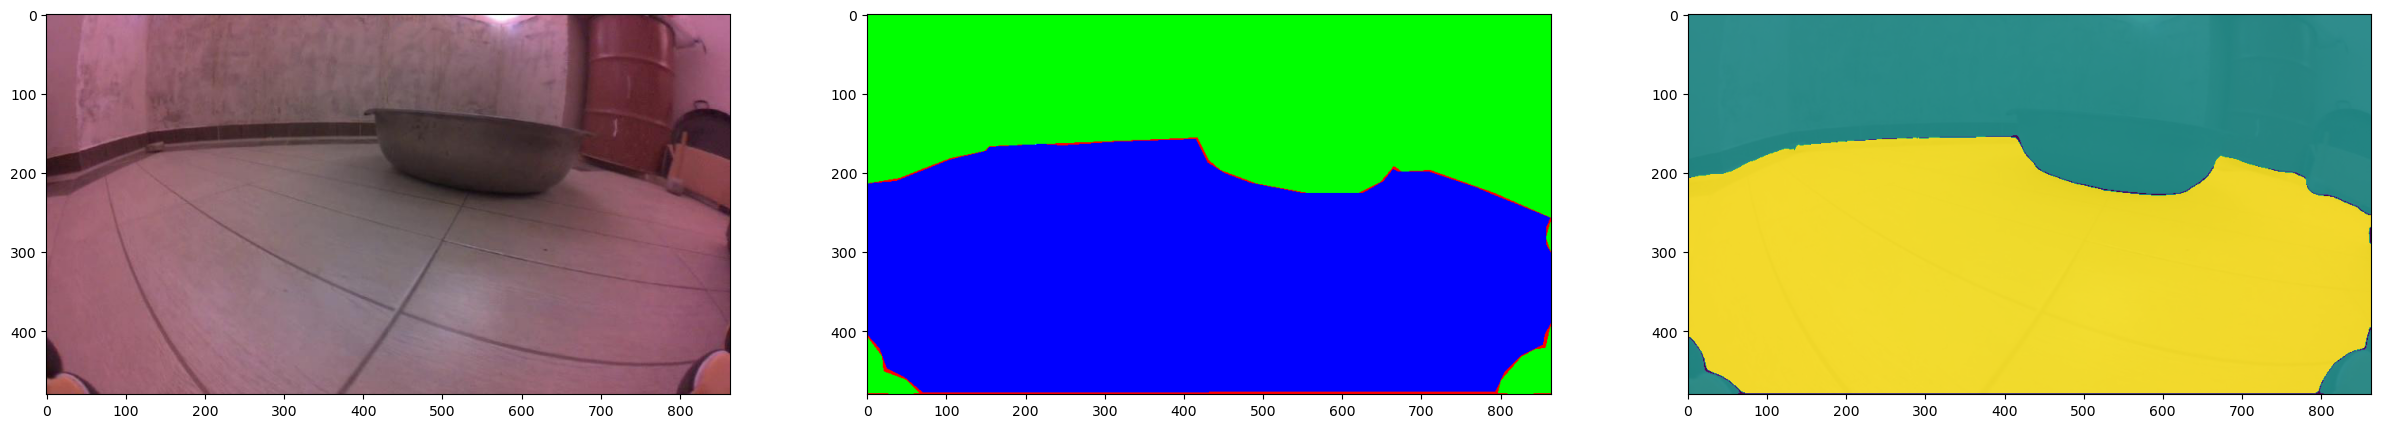

In [40]:
import random

ix = random.randint(0, len(dataset['test']) - 1)
print(ix)
img, mask = dataset['test'][ix]
img_tensor = img.clone().detach().unsqueeze(0).to(device).float()
model.eval()
with torch.no_grad():
    img_tensor.float()
    output = model(img_tensor.to(device).float())[0]
    pred_mask = torch.argmax(output, axis=0) #type: ignore
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
ax2.imshow(mask.squeeze().permute(1, 2, 0).cpu().numpy())
ax3.imshow(img.squeeze().permute(1, 2, 0).cpu().numpy())
a = pred_mask.cpu().numpy()
ax3.imshow(a, alpha=0.9)
#print(a[300], a.max(), a.min())
plt.show()

## Resultados

Precisión de Yolov8: 